In [127]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi,voronoi_plot_2d
%matplotlib inline

Map File Specification
 * The board is a giant equilateral triangle with edge length 1000.
    * Three vertices are `(0, 0)`, `(1000, 0)` and `(500, 500*sqrt(3))`.
 * First line contains 2 integers: `numVoters` and `numParties`.
   They correspond to the number of voters and the number of parties, respectively.
 * The following `numVoters` lines contains the information for each voter.
    * Each line there are `numParties + 2` float numbers.
      First 2 correspond to the location of this voter.
      Later `numParties` numbers are his/her preferences.
 * After `numVoters + 1` lines, there shall be a line containing `0` only.

In [128]:
# Load Data
# Note : The data in coordinate.txt has some error because some points outside the triangular boundary.
#file_path = 'threeParties.map'
#data = np.genfromtxt(file_path,dtype="f8,f8,f8,f8,f8",delimiter=' ',names=['x1','x2','x3','x4','x5'])
#file_path = 'twoParties.txt'
#data = np.genfromtxt(file_path,dtype="f8,f8,f8,f8",delimiter=' ',names=['x1','x2','x3','x4'])
with open('twoParties.map', 'r+') as f:
    content = f.readlines()
f.close()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]
content = content[0:len(content)-1]

In [110]:
# Extract Voters Positions
#V = np.vstack([np.array((x[0],x[1])) for x in data])
# Shuffle the Voters Positions and Randomly Select 333333 Voters
#np.random.shuffle(V)
#V = V[0:333333,:]
V = np.zeros((len(content)-2, 2))
for i in range(1, len(content)-1):
    line = [float(num) for num in content[i].split(" ")]
    x = line[0]
    y = line[1]
    V[i-1, 0] = x
    V[i-1, 1] = y

In [111]:
# Run K-means on Voters to generate 243 clusters.
# Could also use : kmeans = KMeans(n_clusters=243, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(X)
# But MiniBatchKMeans() is faster than KMeans() when N = 333333 and n_clusters = 243
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=81,random_state=0,batch_size=6,max_iter=10).fit(V)

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=18 should be larger than k=81. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=18 should be larger than k=81. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=18 should be larger than k=81. Setting it to 3*k
  init_size=init_size)


(0, 1000)

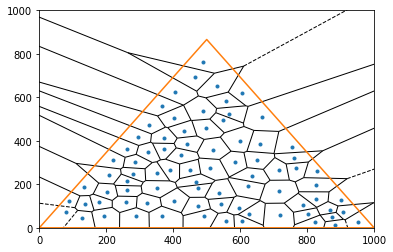

In [112]:
# Generate Voronoi with generator points = cluster centroids
# Note : Some generator points outside tringular boundary due to the error in coordinates.txt data
vor = Voronoi(kmeans.cluster_centers_)
voronoi_plot_2d(vor, show_vertices=False)
plt.plot([0,1000,500,0],[0,0,500*math.sqrt(3),0])
plt.xlim(0,1000)
plt.ylim(0,1000)

In [113]:
from shapely.geometry import Polygon

In [114]:
# Clip the Voronoi Diagram
# Run "conda install shapely -c conda-forge" on terminal first
# Method from StackOverflow
# Reference : https://stackoverflow.com/questions/36063533/clipping-a-voronoi-diagram-python
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [115]:
regions, vertices = voronoi_finite_polygons_2d(vor)

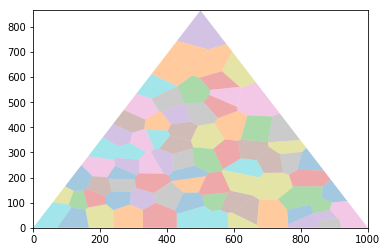

In [116]:
# Box the triangular boundary
box = Polygon([[0, 0], [1000, 0], [500, 500*math.sqrt(3)]])

# Final Output Districts
districts = []

# Colorize Districts
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    districts.append(polygon)
    plt.fill(*zip(*polygon), alpha=0.4)

plt.xlim(0, 1000)
plt.ylim(0, 500*math.sqrt(3))
plt.show()

Result File Specification
 * First `numVoters + 1` lines are exactly the same with the map file.
 * Starting from `numVoters + 2` line, it contains a single integer `numDistricts`
   corresponding to the number of districts.
 * The following `numDistricts` lines describe the shape of districts.
    * Each line starts with an integer `p`, followed by `2p` float numbers describes the
      coordinates of `p` vertices of this district (a polygon).
      The `p` vertices shall be given in order, either clockwise or counter-clockwise.

In [117]:
output = []
for i in range(len(districts)):
    line = []
    line.append(len(districts[i]))
    for j in range(len(districts[i])):
        line.append(districts[i][j][0])
        line.append(districts[i][j][1])
    output.append(line)

In [118]:
with open('result_2_parties.txt', 'w') as f:
    for line in output:
        for item in line:
            f.write('%s ' % item)
        f.write('\n')
f.close()

In [126]:
content = []
with open('twoParties.map', 'r+') as f:
    content = f.readlines()
f.close()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = content[0:len(content)-1]
content.append('81')

output = []
for i in range(len(districts)):
    line = []
    line.append(len(districts[i]))
    for j in range(len(districts[i])):
        line.append(districts[i][j][0])
        line.append(districts[i][j][1])
    output.append(line)

with open('result.txt', 'w') as f:
    f.writelines(content)
    f.write('\n')
    for line in output:
        for item in line:
            f.write('%s ' % item)
        f.write('\n')
f.close()